In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.special import gamma, gammaincc, gammainc
from scipy.integrate import quad
from scipy.stats import gamma as gamma_pdf

In [28]:
def biweight(x, u, s):
    y =  15./(16.*s) * (1.0-((x-u)/s)**2)**2
    y = np.where(np.abs(x-u) <= s, y, 0.0)
    return y

def gamma_pdf_fn(x, a, b):
    y = gamma_pdf.pdf(x, a, scale=1/b)
    y = np.where(x <= 0, 0.0, y)
    return y

In [105]:
sigma = 2.0
mu = 0.0
xvals = np.linspace(-30, 30, 1000)
yvals_norm = norm.pdf(xvals, mu, scale=sigma)
yvals_biweight = biweight(xvals, mu, 3*sigma)
yvals_gamma = gamma_pdf_fn(xvals, 3.75, 2.0)
print(yvals_gamma.shape)
print(yvals_biweight.shape)

(1000,)
(1000,)


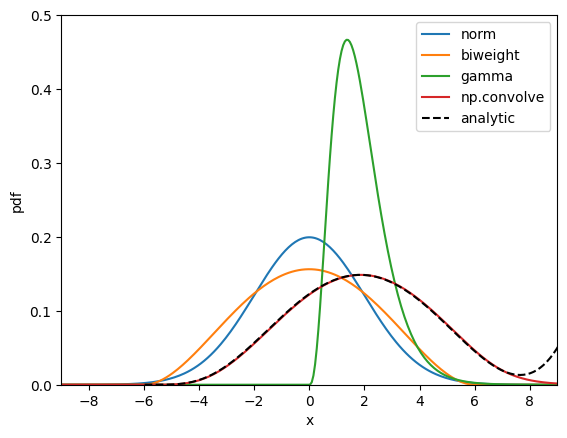

In [106]:
plt.plot(xvals, yvals_norm, label='norm')
plt.plot(xvals, yvals_biweight, label='biweight')
plt.plot(xvals, yvals_gamma, label='gamma')

conv_vals = np.convolve(yvals_gamma, yvals_biweight, 'same')*(xvals[1]-xvals[0])
conv_vals2 = biweight_gamma(xvals, 3.75, 2.0, 3*sigma)
plt.plot(xvals, conv_vals, label='np.convolve')
plt.plot(xvals, conv_vals2, linestyle='dashed', color='black', label='analytic')
plt.xlabel('x')
plt.ylabel('pdf')
plt.xlim([-9.0, 9.0])
plt.ylim([0.0, 0.5])
#plt.yscale('log')
plt.legend()
plt.show()

In [9]:
print(conv_vals[351])
print(xvals[348])

2.5381859817344948e-11
-9.0990990990991


In [10]:
# check normalization
quad(lambda x: biweight(x, 5.0, 9.0), -1000.0, 1000.0)

(0.9999999999935703, 1.1174318041773399e-08)

In [11]:
def biweight_gamma_wrong(x, a, b, s):
    g_a = gamma(a)
    g_1pa = gamma(1+a)
    g_4pa = gamma(4+a)
    g_2pa = gamma(2+a)
    
    pre_fac = 15.0/(16 * b**4 * s**5 * g_a)
    term1 = b**4 * (s**2 - x**2)**2 * g_a + 4*b**3*(s-x)*x*(s+x)*g_1pa + g_4pa

    t1 = -2*(2*(2+a)*x + b*(s**2-3*x**2))*g_2pa
    t2 = b**3 * (s**2 - x**2)**2 * gammaincc(a, b * (s+x))
    t3 = 2*b * (2*b*x*(x-s)*(s+x)*gammaincc(1+a, b*(s+x)) + (s**2-3*x**2)*gammaincc(2+a, b*(s+x)))
    t4 = 4*x* gammaincc(3+a, b*(s + x))
    term2 = b * (t1 - t2 + t3 + t4)

    term3 = gammaincc(4 + a, b*(s + x))
    #print(pre_fac * b)
    #print(t1[:3])
    #print(b * t1[:3] * pre_fac)
    return (term1 + term2 - term3) * pre_fac

In [12]:
def biweight_gamma(x, a, b, s):
    g_a = gamma(a)
    pre_fac = 15.0/(16*b**4*s**5* g_a)
    t = b**4*s**4*gamma(a) - 2*b**4*s**2*x**2*gamma(a) + b**4*x**4*gamma(a) # 1
    t += 4*b**3*s**2*x*gamma(1+a) - 4*b**3*x**3*gamma(1+a) - 2*b**2*s**2*gamma(2+a) # 2
    t += -8*b*x*gamma(2+a) - 4*a*b*x*gamma(2+a) + 6*b**2*x**2*gamma(2+a) # 3
    t += gamma(4+a) - b**4*s**4*gammaincc(a, b*(s+x))*g_a # 4
    t += 2*b**4*s**2*x**2*gammaincc(a, b*(s+x))*g_a - b**4*x**4*gammaincc(a, b*(s+x))*g_a # 5
    t += -4*b**3*s**2*x*gammaincc(1+a, b*(s+x))*gamma(1+a) + 4*b**3*x**3*gammaincc(1+a, b*(s+x))*gamma(1+a) # 6
    t += 2*b**2*s**2*gammaincc(2+a, b*(s+x))*gamma(2+a) - 6*b**2*x**2*gammaincc(2+a, b*(s+x))*gamma(2+a) # 7
    t += 4*b*x*gammaincc(3+a, b*(s+x))*gamma(3+a) - gammaincc(4+a, b*(s+x))*gamma(4+a) # 8
    return pre_fac * t  

In [102]:
def biweight_gamma2(x, a, b, s):
    g_a = gamma(a)
    g_1pa = gamma(1+a)
    g_2pa = gamma(2+a)
    g_4pa = gamma(4+a)

    gincc_a = gammaincc(a, b*(s+x)) * g_a
    gincc_1pa = gammaincc(1+a, b*(s+x))*gamma(1+a)
    gincc_2pa = gammaincc(2+a, b*(s+x))*gamma(2+a)
    gincc_3pa = gammaincc(3+a, b*(s+x))*gamma(3+a)
    gincc_4pa = gammaincc(4+a, b*(s+x))*gamma(4+a)
    
    pre_fac = 15.0/(16*b**4*s**5* g_a)
    
    tsum = g_a * (b**4*s**4 - 2*b**4*s**2*x**2 + b**4*x**4)
    tsum += g_1pa * (4*b**3*s**2*x - 4*b**3*x**3)
    tsum += g_2pa * (6*b**2*x**2 - 2*b**2*s**2 - 8*b*x - 4*a*b*x)
    tsum += g_4pa
    tsum += gincc_a * (-b**4*s**4 + 2*b**4*s**2*x**2 - b**4*x**4)
    tsum += gincc_1pa * (4*b**3*x**3 - 4*b**3*s**2*x)
    tsum += gincc_2pa * (2*b**2*s**2 - 6*b**2*x**2)
    tsum += gincc_3pa * 4*b*x
    tsum -= gincc_4pa

    return pre_fac * tsum

In [13]:
xvals = np.linspace(-9.0, 9.0, 1000)
yvals = biweight_gamma(xvals, 3.75, 2.0, 9.0)

0.01627551838857428


(-9.0, 9.0)

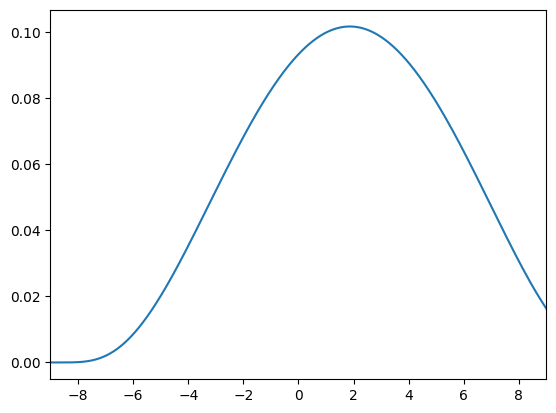

In [14]:
plt.plot(xvals, yvals)
print(yvals[-1])
plt.xlim([-9.0, 9.0])

0.01627551838857428


(1e-07, 1)

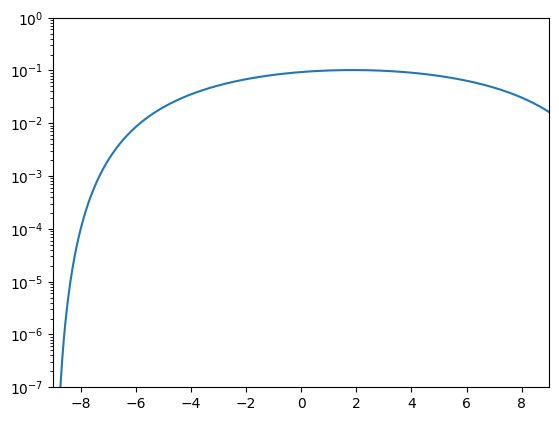

In [17]:
plt.plot(xvals, yvals)
print(yvals[-1])
plt.xlim([-9.0, 9.0])
plt.yscale('log')
plt.ylim([1.e-7, 1])

In [187]:
print(gamma(2+3.75))

78.7844810613232


In [188]:
print(xvals[np.argmax(yvals)])

1.5405405405405403


In [189]:
xvals[np.argmax(yvals)]

1.5405405405405403

In [193]:
biweight_gamma(-5.0, 3.75, 2.0, 9.0)

-0.006275703315886974

In [262]:
def biweight_gamma_term1(x, a, b, s):
    pre_fac = 15.0/(16*b**4*s**5* gamma(a))
    t = b**4*s**4*gamma(a) - 2*b**4*s**2*x**2*gamma(a) + b**4*x**4*gamma(a) # 1
    return t * pre_fac

def biweight_gamma_term2(x, a, b, s):
    pre_fac = 15.0/(16*b**4*s**5* gamma(a))
    t = 4*b**3*s**2*x*gamma(1+a) - 4*b**3*x**3*gamma(1+a) - 2*b**2*s**2*gamma(2+a) # 2
    return t * pre_fac

def biweight_gamma_term3(x, a, b, s):
    pre_fac = 15.0/(16*b**4*s**5* gamma(a))
    t = 8*b*x*gamma(2+a) - 4*a*b*x* + 6*b**2*x**2 # 3
    return t * pre_fac * gamma(2+a)

def biweight_gamma_term4(x, a, b, s):
    pre_fac = 15.0/(16*b**4*s**5* gamma(a))
    t = gamma(4+a) - b**4*s**4*gammaincc(a, b*(s+x))*gamma(a) # 4
    return t * pre_fac

def biweight_gamma_term5(x, a, b, s):
    pre_fac = 15.0/(16*b**4*s**5*gamma(a))
    t = 2*b**4*s**2*x**2 - b**4*x**4 # 5
    return t * pre_fac * gammaincc(a, b*(s+x))* gamma(a)

def biweight_gamma_term6(x, a, b, s):
    pre_fac = 15.0/(16*b**4*s**5*gamma(a))
    t = 4*b**3*s**2*x*gammaincc(1+a, b*(s+x))*gamma(1+a) + 4*b**3*x**3*gammaincc(1+a, b*(s+x))*gamma(1+a)
    return t * pre_fac 

In [208]:
print(biweight_gamma_term1(-5.0, 3.75, 2.0, 9.0)) # good

0.04978915815678505


In [245]:
print(biweight_gamma_term2(-5.0, 3.75, 2.0, 9.0)) # good

-0.04479446492531626


In [210]:
print(biweight_gamma_term3(-5.0, 3.75, 2.0, 9.0)) # good

0.01184236456428136


In [225]:
print(biweight_gamma_term4(-5.0, 3.75, 2.0, 9.0)) # good

-0.002743347962905882


In [243]:
print(biweight_gamma_term5(-5.0, 3.75, 2.0, 9.0)) # good

2.2434838375982898e-07
0.0017902113952547574


In [267]:
print(biweight_gamma_term6(-5.0, 3.75, 2.0, 9.0)) # good

-0.005186401877675158


In [231]:
gammaincc(3.75, 2.0*(9.0-5.0))*gamma(3.75)

0.14561322264418883

In [261]:
gammaincc(1+3.75, 2.0*(9.0-5.0))*gamma(3.75)

0.363484674896582

In [103]:
print(biweight_gamma(0.0, 3.75, 2.0, 9.0))

0.09339912661137627


In [104]:
print(biweight_gamma2(0.0, 3.75, 2.0, 9.0))

0.09339912661137627


In [79]:
from scipy.integrate import quad

In [80]:
fint = lambda x: biweight_gamma2(x, 3.75, 2.0, 9.0)

In [81]:
print(quad(fint, -8.9, 0.0))

(0.3151321442309022, 1.5141461373577897e-09)
